# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [14]:
# import libraries
import os

from pyspark.sql import SparkSession;
from pyspark.sql.functions import isnan,count,when,col, concat, desc, explode, lit, min, max, split, udf, isnull;
from pyspark.sql.types import IntegerType,LongType;

from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import RegexTokenizer, CountVectorizer,IDF, StringIndexer,VectorAssembler, Normalizer, StandardScaler;
from pyspark.ml import Pipeline;
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier,DecisionTreeClassifier,NaiveBayes;
from pyspark.ml.evaluation import MulticlassClassificationEvaluator;

import matplotlib.pyplot as plt;
import pandas as pd;
import seaborn as sns;
import numpy as np;

In [15]:
# create a Spark session
spark = SparkSession\
                    .builder\
                    .master('local')\
                    .appName("Sparkify")\
                    .getOrCreate();
print("spark session created")

spark session created


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [16]:
# loading the data and persisting it
df_user_interactions = spark.read.json('mini_sparkify_event_data.json');
df_user_interactions.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [17]:
# checking the schema
df_user_interactions.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [18]:
#total columns
print('column names =',df_user_interactions.columns,'\n\ntotal columns=',len(df_user_interactions.columns))

column names = ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length', 'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId'] 

total columns= 18


In [19]:
#displaying one sample record
df_user_interactions.createOrReplaceTempView('view_event_data')
spark.sql(" SELECT * FROM view_event_data").take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [20]:
#displaying total rows
#spark.sql(""" SELECT count(*) FROM data""").show() 
str_sql=""" SELECT count(*) FROM view_event_data"""
df=spark.sql(str_sql).toPandas()
df.columns=['count']
df.head()

,count
0,286500


In [21]:
# checking the properties
df_user_interactions.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [22]:
# checking for null values
df_pandas=df_user_interactions.toPandas()
df_pandas.isnull().sum().sort_values()

userId               0
auth                 0
ts                   0
status               0
itemInSession        0
sessionId            0
level                0
page                 0
method               0
registration      8346
location          8346
lastName          8346
gender            8346
firstName         8346
userAgent         8346
length           58392
song             58392
artist           58392
dtype: int64

In [23]:
# drop NAs for not null columns
df_user_interactions = df_user_interactions.dropna(how = 'any', subset = ['userId', 'sessionId','auth','ts','status','itemInSession','level','page','method'])

In [24]:
#checking the UserId for empty string
str_sql="SELECT count(userId) FROM view_event_data where userId=''"
df=spark.sql(str_sql).toPandas()
df.columns=['count']
df.head()

,count
0,8346


In [25]:
str_sql="SELECT userId,count(song) as songs_count FROM view_event_data group by userId"
df=spark.sql(str_sql).toPandas().sort_values(by=['songs_count'],ascending=False)
df.columns=['userid','songs_count']
df.head()

,userid,songs_count
191,39,8002
127,92,5945
69,140,5664
89,300011,4619
4,124,4079


In [26]:
#removing the empty userid records
print('count before deleting = ',df_user_interactions.count())
df_user_interactions=df_user_interactions.filter(df_user_interactions['userId'] != '')
print('count after deleting = ',df_user_interactions.count())
df_user_interactions.createOrReplaceTempView('view_event_data1')

count before deleting =  286500
count after deleting =  278154


### Steps followed for data loading and cleaning
Data has been loaded from json file using spark object and a spark dataframe is created to clean the data. The schema has been checked for the data types and data summary has been checked through describe method. In addition to this, sanctity checks like no of rows, null values for each column has been checked. The userid is an important field and hence userid with empty strings have been removed. 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [27]:

strsql="""select page,count(page) as counts from view_event_data1 group by page order by counts desc"""
spark.sql(strsql).show(100)

+--------------------+------+
|                page|counts|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



### computation of churn
chrun field is computed by creating udf function and by applying it on the each record of Cancellation Confirmation filter of page field

In [28]:
# creaing chrun column based on the Cancellation Confirmation event

def_cancelation_event = udf(lambda p: 1 if p == "Cancellation Confirmation" else 0, IntegerType())

# applying def_cancelation_event to the dataframe
df_user_interactions = df_user_interactions.withColumn("churn", def_cancelation_event("page"))
# window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# apply window
df_user_interactions = df_user_interactions.withColumn("churn", Fsum("churn").over(windowval))

df_user_interactions=df_user_interactions.filter(df_user_interactions['userId'] != '')
df_user_interactions.createOrReplaceTempView('view_event_data2')



In [29]:
# exploring categorical values
# exploring churn
spark.sql("""select churn,count(distinct userId) as users from view_event_data2 group by churn""").show()

+-----+-----+
|churn|users|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [30]:
# exploring Add Friend 
spark.sql("select churn,count(distinct userid) from view_event_data2 where page='Add Friend' group by churn").show()

+-----+----------------------+
|churn|count(DISTINCT userid)|
+-----+----------------------+
|    0|                   162|
|    1|                    44|
+-----+----------------------+



In [20]:
#Add Friend in %
spark.sql("SELECT churn,round(count(1)/count(DISTINCT userId),2) AS AddFriend FROM view_event_data2\
            WHERE page = 'Add Friend' GROUP BY churn").show();

+-----+---------+
|churn|AddFriend|
+-----+---------+
|    0|    22.48|
|    1|    14.45|
+-----+---------+



In [20]:
spark.sql("SELECT churn,count(DISTINCT userId) userid, count(song) song_count FROM view_event_data2\
            GROUP BY churn").show();

+-----+------+----------+
|churn|userid|song_count|
+-----+------+----------+
|    0|   173|    191714|
|    1|    52|     36394|
+-----+------+----------+



In [21]:
# exploring level
spark.sql("select level,count(level) from view_event_data2 group by level").show()

+-----+------------+
|level|count(level)|
+-----+------------+
| free|       55721|
| paid|      222433|
+-----+------------+



In [31]:
# writing function for creating spark queries and for plotting graphs
def spark_feature_queries(strsql):
        """
            This function creates spark dataframe and pandas dataframe by taking sql query as input parameter
            Paremeter:
            
            strsql = string containing sql query
            
            return parameter
            
            df_spark - spark data frame
            df_pandas - pandas dataframe
            
        """
        df_spark=spark.sql(strsql)
        df_pandas=spark.sql(strsql).toPandas()
        return df_spark,df_pandas

def plot_graph(title,df_pandas,palette='muted'):
    """
            This function plots the bargraph using the dataframe passed
            Paremeter:
            
            title = title of the bar graph
            df_pandas = dataframe for the bar graph
            
            return parameter
            
            df_spark - spark data frame
            df_pandas - pandas dataframe
            
     """
    plt.title(title)
    sns.barplot(x=df_pandas.columns[0], y=df_pandas.columns[1], data=df_pandas,palette=palette)
    plt.show();


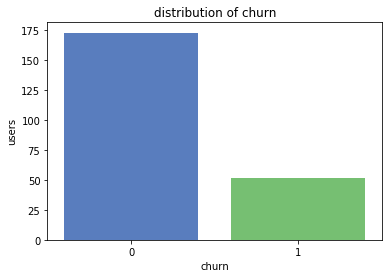

In [32]:
# ploting the churn splits
strsql="""select churn,count(distinct userId) as users from view_event_data2 group by churn"""  
df_spark,df_pandas=spark_feature_queries(strsql)
plot_graph("distribution of churn",df_pandas)

Churn is created based on the Cancellation Confirmation event and data explored for few features based on churn. Data is cleaned up by applying na function and dropped userids with empty strings.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Feature selection and visualization

We will be exploring and visualizing various features before selecting some of them. The features that are of interest are churn, add friend,downgrade,level paid, level free,help, thumbsup, upgrade,session, gender,length and add to play list.

### Feature Song
Song played is a key fields and the number songs played by churn and non churn group is interesting. More songs have been played by non churn users.

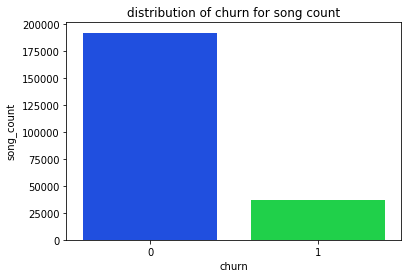

+-----+----------+
|churn|song_count|
+-----+----------+
|    0|    191714|
|    1|     36394|
+-----+----------+



In [33]:
# computing the churn for song played creating a view for final query
strsql= """SELECT churn,count(song) as song_count FROM view_event_data2 group by churn"""
df_spark_songs,df_pandas_songs=spark_feature_queries(strsql)
plot_graph("distribution of churn for song count",df_pandas_songs,'bright')
df_spark_songs.show()

### Feature Add Friend
Churn distribution based on the feature Add friend. The non churn users have added more more friends than non chrun users.

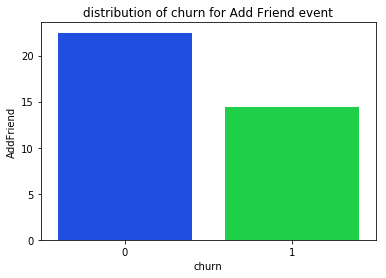

+-----+---------+
|churn|AddFriend|
+-----+---------+
|    0|    22.48|
|    1|    14.45|
+-----+---------+



In [34]:
# computing the churn for add friend page filter and creating a view for final query
strsql= """SELECT churn,round(count(1)/count(DISTINCT userId),2) as AddFriend FROM view_event_data2 WHERE page = 'Add Friend' GROUP BY churn"""
df_spark_addfriend,df_pandas_addfriend=spark_feature_queries(strsql)
plot_graph("distribution of churn for Add Friend event",df_pandas_addfriend,'bright')
df_spark_addfriend.show()

### Feature Downgrade
chrun distribution for downgrade filter on page column

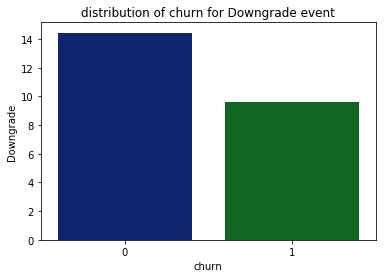

+-----+---------+
|churn|Downgrade|
+-----+---------+
|    0|    14.44|
|    1|     9.63|
+-----+---------+



In [13]:
# computing the chrun for downgrade page filter and creating view for final query
strsql= "SELECT churn,round(count(1)/count(DISTINCT userId),2) as Downgrade FROM view_event_data2 WHERE page = 'Downgrade' GROUP BY churn"
df_spark_downgrade,df_pandas_downgrade=spark_feature_queries(strsql)
plot_graph("distribution of churn for Downgrade event",df_pandas_downgrade,'dark')
df_spark_downgrade.show()

### Feature level paid, level free
chrun distribution for level column. There are two levels paid users and free users. The non churned users are higher in both paid and free categories.

+-----+----------+
|churn|level_paid|
+-----+----------+
|    0|   1472.53|
|    1|    902.11|
+-----+----------+



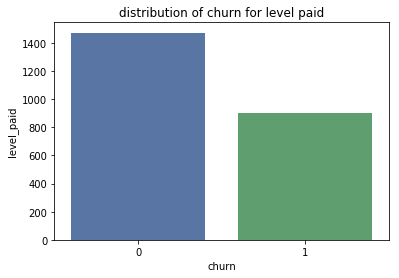

+-----+----------+
|churn|level_free|
+-----+----------+
|    0|    290.83|
|    1|     269.3|
+-----+----------+



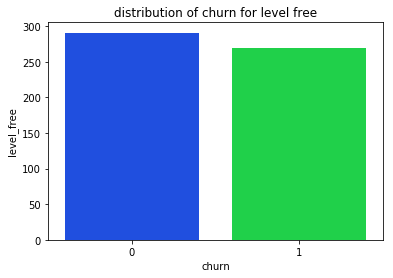

In [28]:
# computing the churn distribution for level paid and free and then creating views for the final query
strsql= "SELECT churn,round(count(1)/count(DISTINCT userId),2) AS level_paid \
    FROM view_event_data2 WHERE level = 'paid' \
    GROUP BY churn"
df_spark_level,df_pandas_level=spark_feature_queries(strsql)
df_spark_level.show()
plot_graph("distribution of churn for level paid",df_pandas_level,'deep')
strsql= "SELECT churn,round(count(1)/count(DISTINCT userId),2) AS level_free \
    FROM view_event_data2 WHERE level = 'free' \
    GROUP BY churn"
df_spark_level,df_pandas_level=spark_feature_queries(strsql)
df_spark_level.show()
plot_graph("distribution of churn for level free",df_pandas_level,'bright')


### Feature Help

+-----+----+
|churn|help|
+-----+----+
|    0|8.15|
|    1|5.56|
+-----+----+



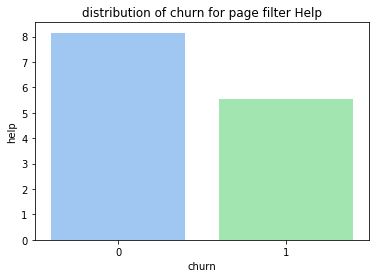

In [29]:
# computing the churn distribution for help filter and then creating views for the final query
strsql= "select churn,round(count(1)/count(DISTINCT userId),2) as help from view_event_data2 WHERE page ='Help' group by churn"
df_spark_help,df_pandas_help=spark_feature_queries(strsql)
df_spark_help.show()
plot_graph("distribution of churn for page filter Help",df_pandas_help,'pastel')


### Feature Thumbsup
63% of the non chruned users have cliked on thumbs up againest 37% by churned users

+-----+--------+
|churn|Thumpsup|
+-----+--------+
|    0|   62.89|
|    1|   37.18|
+-----+--------+



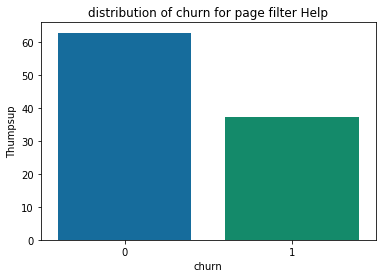

In [30]:
# computing the churn distribution for thumbs up filter and creating a view for final query
strsql="SELECT churn,round(count(1)/count(DISTINCT userId),2) as Thumpsup FROM view_event_data2 WHERE page = 'Thumbs Up' GROUP BY churn"
df_spark_thumbsup,df_pandas_thumbsup=spark_feature_queries(strsql)
df_spark_thumbsup.show()
plot_graph("distribution of churn for page filter Help",df_pandas_thumbsup,'colorblind')


### Feature Upgrade

+-----+-------+
|churn|Upgrade|
+-----+-------+
|    0|   1.25|
|    1|    1.1|
+-----+-------+



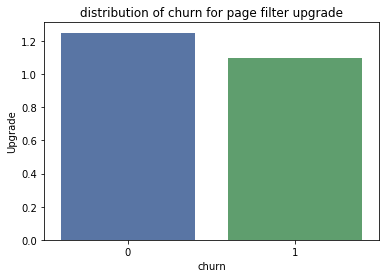

In [31]:
# computing the churn distribution for upgrade filter and creating a view for final query
strsql="SELECT churn,round(count(1)/count(DISTINCT userId),2) as Upgrade FROM view_event_data2 WHERE page = 'Submit Upgrade' GROUP BY churn"
df_spark_upgrade,df_pandas_upgrade=spark_feature_queries(strsql)
df_spark_upgrade.show()
plot_graph("distribution of churn for page filter upgrade",df_pandas_upgrade,'deep')

#spark.sql("select * from view_upgrade").show()

### Feature Session
non churned users have higher nos of sessions than churned users

+-----+--------+
|churn|sessions|
+-----+--------+
|    0| 1198.29|
|    1|  559.48|
+-----+--------+



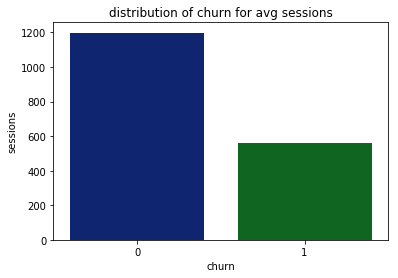

In [32]:
# computing the churn distribution for average sessions and creating a view for final query
strsql="SELECT churn,round(avg(distinct sessionId),2) as sessions FROM view_event_data2 group by churn"
df_spark_session,df_pandas_session=spark_feature_queries(strsql)
df_spark_session.show()
plot_graph("distribution of churn for avg sessions",df_pandas_session,'dark')

#spark.sql("select * from view_sessions").show()

### Feature gender
Female gender distribution is higher for the non churned users. The gender blank records have been treated as Male category

+-----+------+------------+
|churn|gender|gender_count|
+-----+------+------------+
|    0|     0|     1612.02|
|    1|     1|       803.0|
|    1|     0|       958.4|
|    0|     1|     1099.78|
+-----+------+------------+



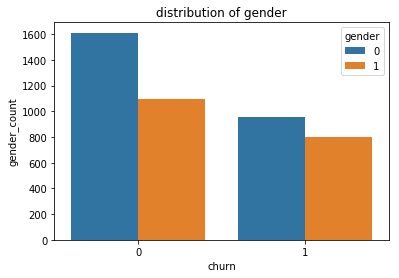

,churn,gender,gender_count
0,0,0,1612.02
1,1,1,803.00
2,1,0,958.40
3,0,1,1099.78


In [33]:
# Gender distribution and creating view for final query
strsql="SELECT churn,case when gender='F' then 0 else 1 end as gender,round(count(1)/count(DISTINCT userId),2) gender_count FROM view_event_data2 GROUP BY churn,gender"
df_spark_gender,df_pandas_gender=spark_feature_queries(strsql)
df_spark_gender.show()
plt.title("distribution of gender");
sns.barplot(x="churn", y="gender_count", hue='gender',data=df_pandas_gender);
plt.show();
df_pandas_gender.head(100)

#spark.sql("select * from view_gender").show()

### Feature length
The length of the song is another key field for data analysis. Non churned users have listened to more songs.

+-----+---------+
|churn|   length|
+-----+---------+
|    0|276166.94|
|    1|174014.27|
+-----+---------+



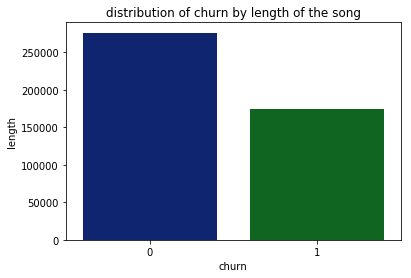

In [34]:
#computing the length of the music split by churn
strsql="select churn,round(sum(length)/count(distinct userId),2) as length from view_event_data2\
          where page = 'NextSong' GROUP BY  churn"
df_spark_length,df_pandas_length=spark_feature_queries(strsql)
df_spark_length.show()
plot_graph("distribution of churn by length of the song",df_pandas_length,'dark')


#spark.sql("select * from view_length").show()

### Feature Add to playlist

+-----+--------+
|churn|playlist|
+-----+--------+
|    0|   33.26|
|    1|   20.76|
+-----+--------+



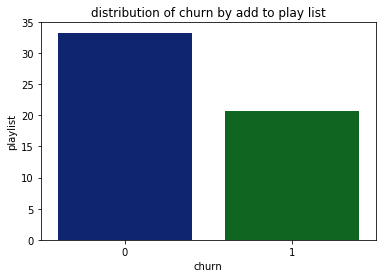

In [35]:
#computing churn split by add to playlist
strsql="SELECT churn,round(count(1)/count(DISTINCT userId),2)  as playlist FROM view_event_data2\
                        WHERE page ='Add to Playlist' GROUP BY churn"
df_spark_playlist,df_pandas_playlist=spark_feature_queries(strsql)
df_spark_playlist.show()
plot_graph("distribution of churn by add to play list",df_pandas_playlist,'dark')


#spark.sql("select * from view_playlist").show()

In [35]:
#creating views for the final data model
strsql="select distinct userid,churn from view_event_data2"
spark.sql(strsql).createOrReplaceTempView('view_churn')
strsql="select distinct userid from view_event_data2"
spark.sql(strsql).createOrReplaceTempView('view_users')

spark.sql("SELECT DISTINCT(userId),count(song) as song_count FROM view_event_data2\
       GROUP BY userId").createOrReplaceTempView('view_songs');

spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS Friends FROM view_event_data2\
        WHERE page = 'Add Friend' GROUP BY userId").createOrReplaceTempView('view_addfriend');

spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS Downgrade FROM view_event_data2\
                        WHERE page ='Downgrade' GROUP BY userId").createOrReplaceTempView('view_downgrade');

spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS level_paid FROM view_event_data2\
                    WHERE level = 'paid' GROUP BY userId").createOrReplaceTempView('view_level_paid');

spark.sql("SELECT DISTINCT(userId),count(1)/count(DISTINCT userId) AS level_free FROM view_event_data2\
                    WHERE level = 'free' GROUP BY userId").createOrReplaceTempView('view_level_free');

spark.sql("SELECT DISTINCT(userId),round(count(1)/count(DISTINCT userId),2) as help FROM view_event_data2\
                        WHERE page ='Help' GROUP BY userId").createOrReplaceTempView('view_help');

spark.sql("SELECT DISTINCT(userId),round(count(1)/count(DISTINCT userId),2) AS Thumpsup \
    FROM view_event_data2 WHERE page = 'Thumbs Up' GROUP BY userId").createOrReplaceTempView('view_thumpsup');

spark.sql("SELECT DISTINCT(userId),round(count(1)/count(DISTINCT userId),2) AS Upgrade \
    FROM view_event_data2 WHERE page = 'Submit Upgrade' GROUP BY userId").createOrReplaceTempView('view_upgrade');

spark.sql("SELECT DISTINCT(userId),round(avg(distinct sessionId),2) as sessions FROM view_event_data2 group\
                            by userId").createOrReplaceTempView('view_sessions');

spark.sql("SELECT DISTINCT(userId),case when gender='F' then 0 \
                            else 1 end as gender_count FROM view_event_data2").createOrReplaceTempView('view_gender');

spark.sql("select distinct(userId),round(sum(nvl(length, 0)),2) as length FROM view_event_data2\
                              where page = 'NextSong' GROUP BY userId").createOrReplaceTempView('view_length');

spark.sql("select DISTINCT(userId),round(count(1)/count(DISTINCT userId),2) as playlist FROM view_event_data2\
            WHERE page ='Add to Playlist' GROUP BY userId").createOrReplaceTempView('view_playlist');

print('user views created')

user views created


In [36]:
#creating a summary query to create a data frame for the input to ml
strsql=""
strsql="select a.userId,m.churn,b.Friends,c.Downgrade,d.level_free,e.level_paid,f.help,g.Thumpsup"
strsql=strsql + ",h.sessions,i.gender_count,k.length,l.playlist,n.song_count from view_users as a left outer join"
strsql=strsql + " view_addfriend as b on a.userid=b.userid left outer join"
strsql=strsql + " view_downgrade as c on a.userid=c.userId  left outer join"
strsql=strsql + " view_level_free as d on a.userid=d.userId  left outer join"
strsql=strsql + " view_level_paid as e on a.userid=e.userId  left outer join"
strsql=strsql + " view_help as f on a.userid=f.userId  left outer join"
strsql=strsql + " view_thumpsup as g on a.userid=g.userId  left outer join"
strsql=strsql + " view_sessions as h on a.userid=h.userId  left outer join"
strsql=strsql + " view_gender as i on a.userid=i.userId  left outer join"
strsql=strsql + " view_length as k on a.userid=k.userId  left outer join"
strsql=strsql + " view_playlist as l on a.userid=l.userId  left outer join"
strsql=strsql + " view_churn as m on a.userid=m.userId left outer join"
strsql=strsql + " view_songs as n on a.userid=n.userId"

#print(strsql)
spark.sql(strsql).createOrReplaceTempView('view_user_aggregates')
df_spark_usr_aggregates=spark.sql("select * from view_user_aggregates")

print('total rows =', df_spark_usr_aggregates.count())
print('total columns =', len(df_spark_usr_aggregates.columns))
print('column names =',df_spark_usr_aggregates.columns)
spark.sql("select * from view_user_aggregates").show(5)

total rows = 225
total columns = 13
column names = ['userId', 'churn', 'Friends', 'Downgrade', 'level_free', 'level_paid', 'help', 'Thumpsup', 'sessions', 'gender_count', 'length', 'playlist', 'song_count']
+------+-----+-------+---------+----------+----------+----+--------+--------+------------+----------+--------+----------+
|userId|churn|Friends|Downgrade|level_free|level_paid|help|Thumpsup|sessions|gender_count|    length|playlist|song_count|
+------+-----+-------+---------+----------+----------+----+--------+--------+------------+----------+--------+----------+
|100010|    0|    4.0|     null|     381.0|      null| 2.0|    17.0|  119.14|           0|   66940.9|     7.0|       275|
|200002|    0|    4.0|      5.0|     120.0|     354.0| 2.0|    21.0|   117.0|           1|  94008.88|     8.0|       387|
|   125|    1|   null|     null|      11.0|      null|null|    null|   174.0|           1|   2089.11|    null|         8|
|    51|    1|   28.0|     23.0|      null|    2464.0|12.0|  

In [37]:
df_spark_usr_aggregates.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: long (nullable = true)
 |-- Friends: double (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- level_free: double (nullable = true)
 |-- level_paid: double (nullable = true)
 |-- help: double (nullable = true)
 |-- Thumpsup: double (nullable = true)
 |-- sessions: double (nullable = true)
 |-- gender_count: integer (nullable = true)
 |-- length: double (nullable = true)
 |-- playlist: double (nullable = true)
 |-- song_count: long (nullable = true)



In [38]:
df_pandas_features=spark.sql("select * from view_user_aggregates").toPandas()
df_pandas_features.isnull().sum().sort_values()

userId           0
churn            0
sessions         0
gender_count     0
length           0
song_count       0
Thumpsup         5
playlist        10
Friends         19
level_free      30
help            33
level_paid      60
Downgrade       71
dtype: int64

In [39]:
#replacing null values
strsql="SELECT nvl(userid,0) as userid ,nvl(sessions,0) as sessions,nvl(gender_count,0) as gender,nvl(length,0) as length,"
strsql=strsql+"nvl(thumpsup,0) as thumpsup,nvl(playlist,0) as playlist,"
strsql=strsql+"nvl(friends,0) as friends,nvl(level_free,0) as level_free,nvl(help,2) as help,"
strsql=strsql+"nvl(level_paid,0) as level_paid,nvl(downgrade,0) as downgrade,nvl(song_count,0) as songs,"
strsql=strsql+"nvl(churn,0) as label FROM view_user_aggregates"
#print(strsql)
#creating feature table after handling nulls

view_user_features_ml=spark.sql(strsql)
view_user_features_ml.createOrReplaceTempView('view_user_features_ml')
spark.sql('select * from view_user_features_ml').show(5)
print(spark.sql(strsql).toPandas().isnull().sum())

+------+--------+------+----------+--------+--------+-------+----------+----+----------+---------+-----+-----+
|userid|sessions|gender|    length|thumpsup|playlist|friends|level_free|help|level_paid|downgrade|songs|label|
+------+--------+------+----------+--------+--------+-------+----------+----+----------+---------+-----+-----+
|100010|  119.14|     0|   66940.9|    17.0|     7.0|    4.0|     381.0| 2.0|       0.0|      0.0|  275|    0|
|200002|   117.0|     1|  94008.88|    21.0|     8.0|    4.0|     120.0| 2.0|     354.0|      5.0|  387|    0|
|   125|   174.0|     1|   2089.11|     0.0|     0.0|    0.0|      11.0| 2.0|       0.0|      0.0|    8|    1|
|    51|   640.3|     1| 523275.84|   100.0|    52.0|   28.0|       0.0|12.0|    2464.0|     23.0| 2111|    1|
|   124| 1394.34|     0|1012312.09|   171.0|   118.0|   74.0|       0.0|23.0|    4825.0|     41.0| 4079|    0|
+------+--------+------+----------+--------+--------+-------+----------+----+----------+---------+-----+-----+
o

### Correlation analysis
Length,thumbsup,playlists, friends, downgrade and songs higher corrlation and others fields have poor correlation

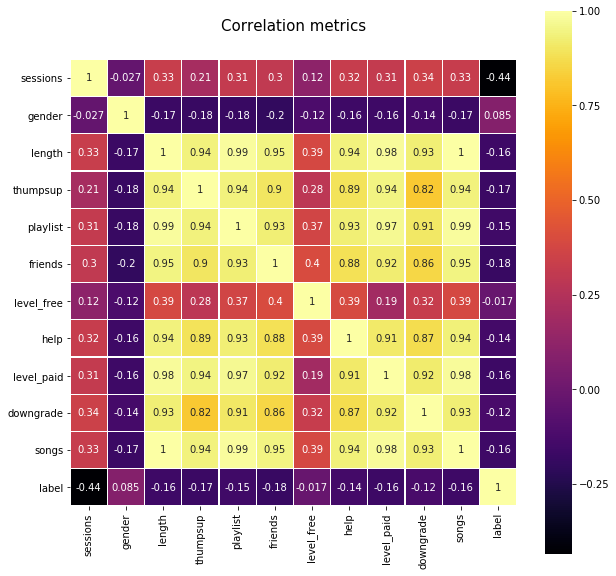

In [42]:
#analyising the correlation metrcis
plt.figure(figsize=(10,10))
plt.title('Correlation metrics', y=1.05, size=15)
sns.heatmap(view_user_features_ml.toPandas().corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=plt.cm.inferno, linecolor='white', annot=True)

In [40]:
#saving the data to csv file
filename = "sparkify_save_data1.csv"
try:
    os.remove(filename)
except:
    print("file does not exists")
df_save=spark.sql('select * from view_user_features_ml')
df_save.toPandas().to_csv(filename)
print('file saved')

file saved


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [41]:
df_features_ml = spark.read.csv(filename, header=True)
df_features_ml.persist()
df_features_ml.show(5)

+---+------+--------+------+----------+--------+--------+-------+----------+----+----------+---------+-----+-----+
|_c0|userid|sessions|gender|    length|thumpsup|playlist|friends|level_free|help|level_paid|downgrade|songs|label|
+---+------+--------+------+----------+--------+--------+-------+----------+----+----------+---------+-----+-----+
|  0|100010|  119.14|     0|   66940.9|    17.0|     7.0|    4.0|     381.0| 2.0|       0.0|      0.0|  275|    0|
|  1|200002|   117.0|     1|  94008.88|    21.0|     8.0|    4.0|     120.0| 2.0|     354.0|      5.0|  387|    0|
|  2|   125|   174.0|     1|   2089.11|     0.0|     0.0|    0.0|      11.0| 2.0|       0.0|      0.0|    8|    1|
|  3|    51|   640.3|     1| 523275.84|   100.0|    52.0|   28.0|       0.0|12.0|    2464.0|     23.0| 2111|    1|
|  4|   124| 1394.34|     0|1012312.09|   171.0|   118.0|   74.0|       0.0|23.0|    4825.0|     41.0| 4079|    0|
+---+------+--------+------+----------+--------+--------+-------+----------+----

In [42]:
#ML models and pipe line creation
vector_assembler = VectorAssembler(inputCols=["sessions","gender","length","downgrade",\
                                       "friends","level_paid","level_free","thumpsup","songs"],\
                            outputCol="inputFeatures")

#Lets normalize data
normalizer = Normalizer(inputCol="inputFeatures", outputCol="ScaledFeatures");
print("model created")


model created


In [43]:
#model creation
model_lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", maxIter=10, regParam=0.05)
model_rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label")
model_gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")
model_nv = NaiveBayes(featuresCol="ScaledFeatures", labelCol="label")
model_dt = DecisionTreeClassifier(featuresCol="ScaledFeatures", labelCol="label")

print('model added')

model added


In [44]:
#Create Pipeline
pipeline_lr = Pipeline(stages=[vector_assembler, normalizer, model_lr]);
pipeline_rf = Pipeline(stages=[vector_assembler, normalizer, model_rf]);
pipeline_gbt = Pipeline(stages=[vector_assembler, normalizer, model_gbt])
pipeline_nv = Pipeline(stages=[vector_assembler, normalizer, model_nv])
pipeline_dt = Pipeline(stages=[vector_assembler, normalizer, model_dt])
print('pipeline created')

pipeline created


In [45]:
# spilt data for Train and test 
df_features=df_features_ml.select("sessions","gender","length","downgrade","friends","level_paid","level_free","thumpsup","songs","label")
df_features = df_features.withColumn("sessions", df_features["sessions"].cast(IntegerType()))
#df_features = df_features.withColumn("playlist", df_features["playlist"].cast(IntegerType()))
df_features = df_features.withColumn("length", df_features["length"].cast(IntegerType()))
df_features = df_features.withColumn("downgrade", df_features["downgrade"].cast(IntegerType()))
df_features = df_features.withColumn("friends", df_features["friends"].cast(IntegerType()))
df_features = df_features.withColumn("level_paid", df_features["level_paid"].cast(IntegerType()))
df_features = df_features.withColumn("level_free", df_features["level_free"].cast(IntegerType()))
df_features = df_features.withColumn("gender", df_features["gender"].cast(IntegerType()))
df_features = df_features.withColumn("thumpsup", df_features["thumpsup"].cast(IntegerType()))
df_features = df_features.withColumn("songs", df_features["songs"].cast(IntegerType()))
df_features = df_features.withColumn("label", df_features["label"].cast(IntegerType()))



training, test = df_features.randomSplit([0.8, 0.2]);
print('dataset created')

dataset created


In [47]:
#fitting the model
model_lr_fitted = pipeline_lr.fit(training);
model_rf_fitted = pipeline_rf.fit(training);
model_gbt_fitted = pipeline_gbt.fit(training)
model_nv_fitted = pipeline_nv.fit(training)
model_dt_fitted = pipeline_dt.fit(training)
print('models executed')


models executed


In [48]:
def accuracy_f1(modelname,model, test_data):
    """ 
    This function computes the accuracy and f1 scores using MulticlassClassificationEvaluator
        Parameters :
        -------------------
            modelname- name of the model
            model- trained model
            test_data - test data for computation of accuracy and F1 scores
        Return values:
            None
    """
    #accuracy computation
    eval_accuracy = MulticlassClassificationEvaluator(metricName = 'accuracy')
    predic_accuracy = model.transform(test_data)
    accuracy = eval_accuracy.evaluate(predic_accuracy)
    accuracy=round(accuracy,2)
  
    #F1 score computation
    eval_f1 = MulticlassClassificationEvaluator(metricName = 'f1')
    prediction_f1 = model.transform(test_data)
    f1_score = eval_f1.evaluate(prediction_f1)
    f1_score=round(f1_score,2)
    print(modelname, ' - Accuracy =',accuracy,', F1-Score = ',f1_score)
    
    return None

accuracy_f1('LogisticRegression',model_lr_fitted, test);
accuracy_f1('RandomForest',model_rf_fitted, test);
accuracy_f1('GBTClassifier',model_gbt_fitted, test);
accuracy_f1('NaiveBayes',model_nv_fitted, test);
accuracy_f1('DecisionTreeClassifier',model_dt_fitted, test);

LogisticRegression  - Accuracy = 0.8 , F1-Score =  0.73
RandomForest  - Accuracy = 0.82 , F1-Score =  0.78
GBTClassifier  - Accuracy = 0.85 , F1-Score =  0.83
NaiveBayes  - Accuracy = 0.78 , F1-Score =  0.68
DecisionTreeClassifier  - Accuracy = 0.82 , F1-Score =  0.8


### Conclusion
In this project the sparkify logs data has been explored by considering 12 features. The basic goal of this analysis is to 

identify the churned users. The features used for the data exploration and modelling are count of songs played, length of 

the songs, add friend, downgrade, upgrade, playlist, level paid, level free, help and sessions. Churn will be the labeled 

column. 

The data has been explored through the spark sql and pandas has been used for plotting bar graphs. The spark ml has been used 

for the ml modules and pipeline creation. The data model has been tested with five  modules algorithms  LogisticRegression, 

RandomForest, GBTClassifer, NaiveBayes and DecisionTreeClassifier.  GBT Classifer has given highest accuracy of 85% and F1 

score of 83%.

By identifying the churning customers, the companies can focus on promotional activities like access to more content, 

incentives and extension of the validity period etc.

### Reflections

Working on this project has been a great experience. The spark sql is very easy to use and spark ml modules provide most of the 

libraries learned in the previous chapters like sklearn. I have gained good experience working in this project.The availability 

of spark cluster through jupyter notebook is really helpful as setting up of local cluster on the laptop is very difficult. 



### Improvements

There is a good potential for extracting more features through the fields like user agent, method, status, timestamp etc.More 

deeper analysis can be done through these fields. Text processing tools like nltk can used to extract the OS, browser details 

etc. 



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.